<a href="https://colab.research.google.com/github/DamiAladesuru/MachineLearning2023/blob/main/6800_Day3-4_Damilola_Aladesuru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 3/4: Code used during lecture and lab assignment

## Instructions

- The notebook combines 'code used during lecture' with the corresponding lab assignment (see further down)
- The lab assignment can be done largely by copying/paste/modification of the code used during the lecture
- Please add answers/discussion/comments to the notebook as comments or text box. Do not create another file in addition.
- When you are done with your assignment, save the notebook in drive and add your last name to the name of the file.
- To hand in the final notebook follow the instructions provided by email

### Notes:
- The first part of the notebook contains code from the shapeley value lecture (day 3), the second part comprises all the code on NN (days 3 and 4).  
- The intention of the NN part of the notebook is somewhat different from the notebooks for the other days. Here, we do not aim for fitting an optimal model. The steps that we take here are not an illustration of how you would actually approach an estimation task. Instead we want to play around with a NN in serveral ways to build your understanding of how NN work.
- We begin with a NN used for autoencoding and then move towards using a NN for prediction

### Code used during lecture

In [2]:
import numpy as np
import pandas as pd
import scipy as sc
import datetime, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA



# Set the numpy random seed
np.random.seed(100)

### Load the data

In [3]:
# run this cell only once if you don't have wget installed
# its assumed you are using windows and have python installed
# only needed if you are running the notebook locally
# %pip install wget
#if not os.path.isfile('brazil_all_data_v2.gz'):
#    !python -m wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz
# Download data only once and make sure it is in the same folder as the notebook

# check if brazil_all_data_v2.gz is available in the current folder and if not, download it

if not os.path.isfile('brazil_all_data_v2.gz'):
    !wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz


In [4]:
# load data into dataframe
df = pd.read_parquet('brazil_all_data_v2.gz')

In [5]:
# Define binary variable for deforestration in 2018 as in lab day 2
df['D_defor_2018'] = df['defor_2018']>0
Y_all = df['D_defor_2018']

In [6]:
## Prepare the data
# list(df.columns[~df.columns.str.contains('2018')])
# Variables from day 2
lstX = [
  'wdpa_2017',
  'population_2015',
  'chirps_2017',
  'defor_2017',
  'maize',
  'soy',
  'sugarcane',
  'perc_treecover',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
  'defor_2017_lag_1st_order',
  'wdpa_2017_lag_1st_order',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

X_all = df.loc[:,lstX]

In [7]:
# Split the data into train and test data using sklearn train_test_split object
#   (see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

#   Note: This randomly split the data in 80% train and 20% test data
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2)

In [8]:
# MinMax scale data
from sklearn.preprocessing import MinMaxScaler
scalerX = MinMaxScaler()
X_train = scalerX.fit_transform(X_train_raw)
X_test = scalerX.transform(X_test_raw)


In [9]:
# Define helper function that we will use below to print the stats of each model
def printOutput(Y_score,Y_true):

  # Get true positive and false positive rate
  # See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
  fpr_Lg, tpr_Lg, _ = roc_curve(Y_true, Y_score)

  # Get the Area under the cureve (AUC)
  # See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
  roc_auc_Lg = auc(fpr_Lg, tpr_Lg)

  print('\nROC AUC', roc_auc_Lg)

  # Plot the ROC curve
  plt.figure()
  lw = 2
  plt.plot(fpr_Lg, tpr_Lg, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f' % roc_auc_Lg)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

# **Part One: SHAP Values**
The first part of the lab focus on SHAP values. First we show you how to plot SHAP values for the XG Boost model, which you have already seen in the lecutre and the lab session in the previous day. Then you  should create SHAP values for the logit model and explore how SHAP value would look like in a well known linear model.

More on SHAP values:

https://github.com/slundberg/shap


In [10]:
# Fit a logistic regression model using sklearn
# (see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

# Create the model object
modelLg = LogisticRegression(random_state=0,penalty=None,fit_intercept=True,max_iter=1000)
# Fit the model using the training data
modelLg.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, penalty=None, random_state=0)

In [11]:
from sklearn import tree
# Fit a decision tree using sklearn
# (see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

# Define a model object
modelTree = tree.DecisionTreeClassifier()
# Fit the model
modelTree = modelTree.fit(X_train, Y_train)

In [12]:
# run a random forest using sklearn and default hyperparameters (note, this will take a few minutes)
# (see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
from sklearn.ensemble import RandomForestClassifier

# Create model object
modelForest = RandomForestClassifier()
# Fit model
modelForest = modelForest.fit(X_train, Y_train)

In [13]:
%pip install xgboost

In [14]:
# Now run an XGBoost model for the same task
import xgboost as xgb
model_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Fit model to data
model_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [15]:
# First install the SHAP libary
!pip install shap

In [16]:
# Import the shape libary
import shap
# Load JS visualization code to notebook
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [17]:
# Create a dataframe for our train data that includes the variable names
df_X_train = pd.DataFrame(X_train,columns=lstX)

# Explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_xgb)

# Calculate the shape values using the TreeExplainer object
shap_values = explainer.shap_values(df_X_train)

In [18]:
# Get predicted probabilities to compare shape values
Y_train_proba = model_xgb.predict_proba(X_train)

In [19]:
# Inspect shape of SHAP values
shap_values.shape

(199952, 28)

(array([ 3., 11.,  5.,  3.,  2.,  3.,  0.,  0.,  0.,  1.]),
 array([-0.10655038, -0.03987292,  0.02680454,  0.093482  ,  0.16015947,
         0.22683692,  0.2935144 ,  0.36019185,  0.4268693 ,  0.49354678,
         0.56022424]),
 <BarContainer object of 10 artists>)

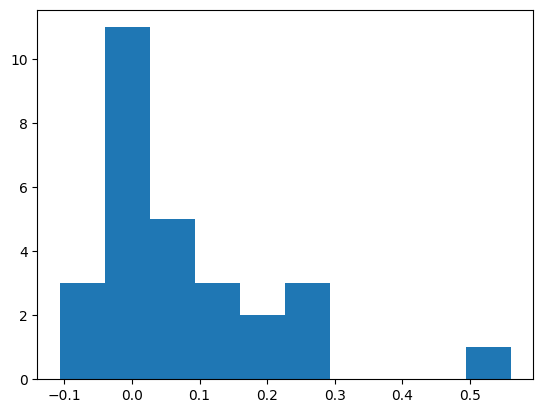

In [20]:
plt.hist(shap_values[lstX.index('defor_2017')])

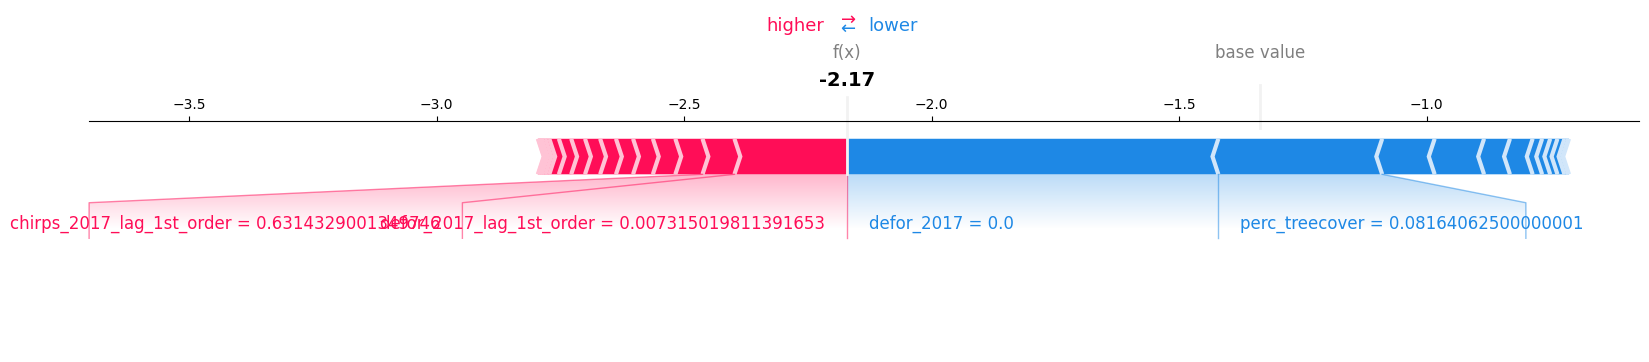

In [21]:
# visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value, shap_values[0,:], df_X_train.iloc[0,:])
iobs = 1
# If you have a javascript error use matplotlib=True to avoid Javascript
shap.force_plot(explainer.expected_value, shap_values[iobs,:], df_X_train.iloc[iobs,:],matplotlib=True)

# Note: This might look different than the version the slides because another random seed
#       was used to create the plots in the slides

In [22]:
# Explore shape values manually
shap_iobs = explainer.expected_value + shap_values[iobs,:].sum()
print(f'SHAP value of obs {iobs}:',shap_iobs)
print('SHAP value for base:', explainer.expected_value)

# SHAP value are in log-odds, transform to probability
print('Expected Prob:',np.exp(explainer.expected_value) / (1 + np.exp(explainer.expected_value)))
print(f'Prob of obs {iobs}:',np.exp(shap_iobs) / (1 + np.exp(shap_iobs)))

# compare to predicted proability
print(f'Proba of obs {iobs}:', Y_train_proba[iobs][1])

SHAP value of obs 1: -2.1718066
SHAP value for base: -1.3364447
Expected Prob: 0.20809532621537713
Prob of obs 1: 0.10231099706571384
Proba of obs 1: 0.10231097


In [23]:
# ====================
# Discuss in the group
# ====================
# How do you interpret this plot?
# largest shap calue, feature with largest diff between average X and Xi. Negative log odds when X value = 0, less than 0.5 probability of deforestation in Yth year
# When might you want to use a plot like this?
# the plot helps to understand the deviation from the average X to the Xith value of a feature resulting in the predicted Yith value of an observation.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


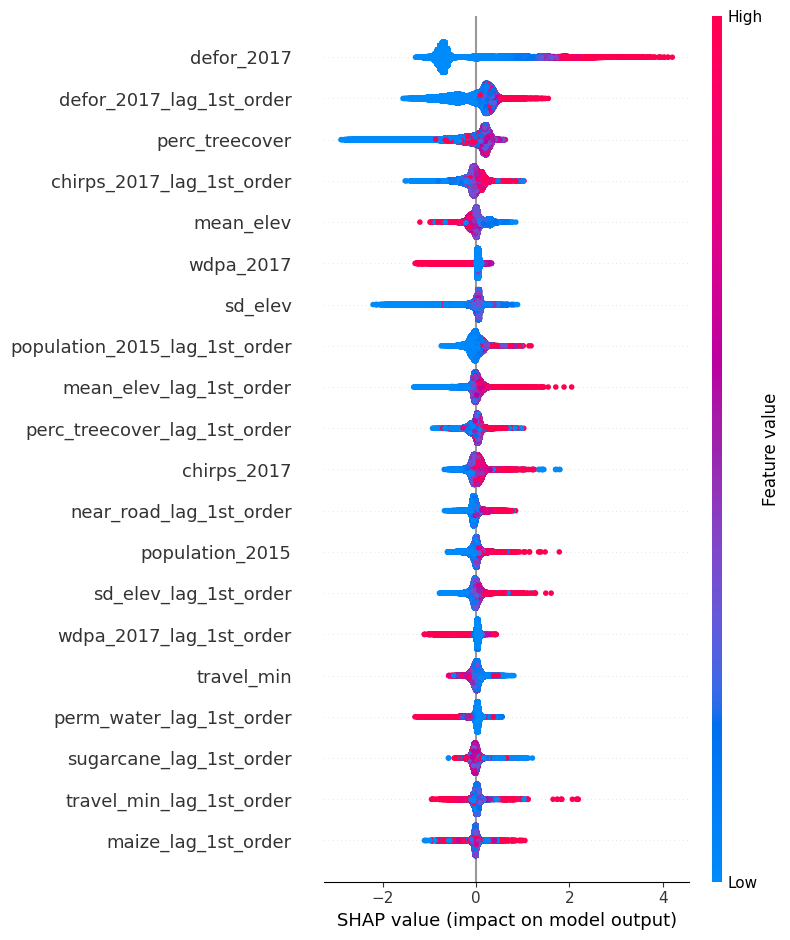

In [24]:
# summarize the effects of all the features
shap.summary_plot(shap_values, df_X_train)

In [25]:

# ====================
# Discuss in the group
# ====================
# How do you interpret this plot?
# several observation with low feature values have also - SHAP value however there are features where observations with high and low feature values have positive SHAP values

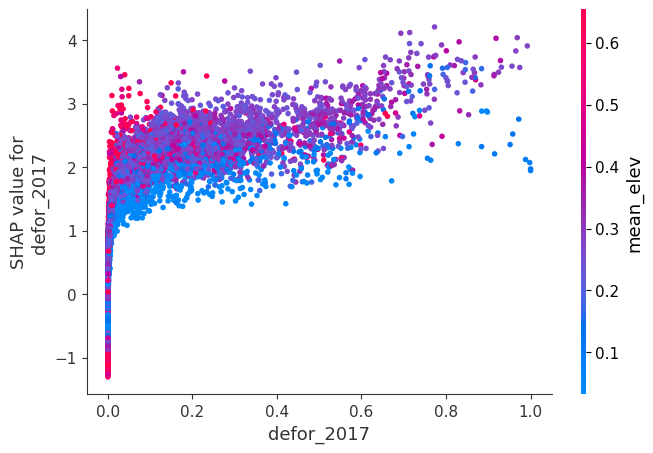

In [26]:

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("defor_2017", shap_values, df_X_train)

In [27]:
# ====================
# Discuss in the group
# ====================
# How do you interpret this plot?

In [28]:
# ====================
# Discuss in the group
# ====================
# Before you start creating the plots, discuss in the group what kind of
# results you expect for the linear model. Specifically, think about how the
# last plot (the dependence_plot) would look in this case.

In [31]:
# Here we use the shap.LinearExplainer() function instead of the
# shap.TreeExplainer(...) we used above

# You can have a look here for a reference:
# https://slundberg.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html

# ==============
# Your code here
# ==============
explainer_linear = shap.LinearExplainer(modelLg, masker=shap.maskers.Impute(data=X_train))

shap_values_linear = explainer_linear.shap_values(df_X_train)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

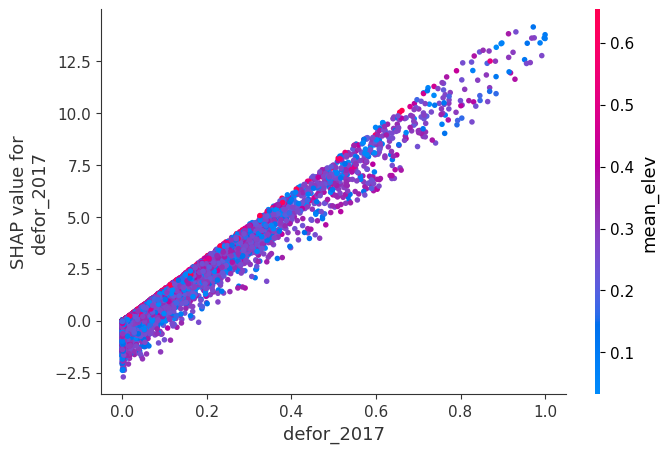

In [32]:
# Now create a dependence plot to show the effect of a single feature
# across the whole dataset, as was done above but now for the logit model

# ==============
# Your code here
# ==============
shap.dependence_plot("defor_2017", shap_values_linear, df_X_train, interaction_index = "mean_elev")

In [ ]:
# ====================
# Discuss in the group
# ====================


# 1) Does this look like to what you expected?

# 2) How does this compare to the plot for the XGB model. What can you conclude?

# Note: Below you find the usual regression output for logit model again. This
#       might be interesting as a reference.

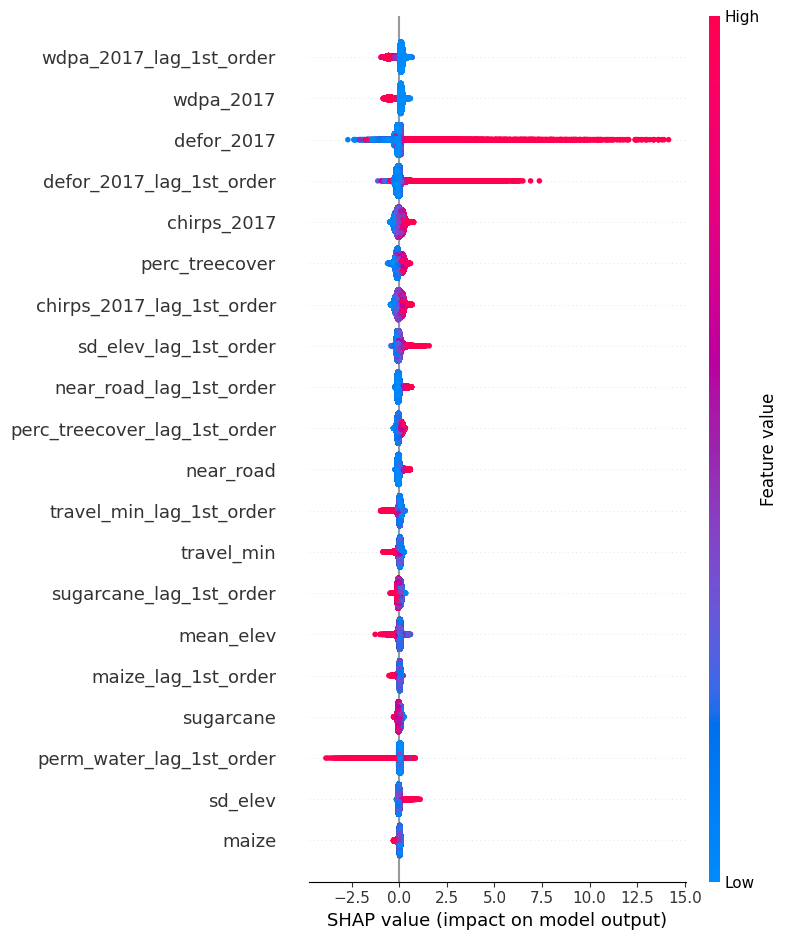

In [34]:

# Have a look at the SHAP summary plot
shap.summary_plot(shap_values_linear, df_X_train)

## **For your reference**

Lets create our usual regression output for the logit model as a reference

This used the same code from the lab intro session.

(Not need to change/do anything here)

In [35]:
from scipy.stats import norm
# Function to calculate pvalues and standard errors for a scikit-learn logisticRegression
# Source: https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    # m = len(model.coef_[0])
    # coefs = model.coef_[0]
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se
    p = (1 - norm.cdf(abs(t))) * 2
    return se, p

In [36]:
# Use the previously created function to create a regression output table
se, p = logit_pvalue(modelLg, X_train)
coefs = np.concatenate([modelLg.intercept_, modelLg.coef_[0]]).T
resCoef = pd.DataFrame(coefs,index=['constant']+lstX)
resCoef.columns = ['coef']
resCoef['se'] = se
resCoef['pval'] = p
resCoef

,coef,se,pval
constant,-1.928943,0.034340,0.000000e+00
wdpa_2017,-0.480968,0.064109,6.261658e-14
population_2015,-0.394487,0.592005,5.051827e-01
chirps_2017,-0.934422,0.690506,1.759778e-01
defor_2017,13.997626,0.285571,0.000000e+00
maize,2.034888,0.771636,8.361645e-03
soy,-0.651793,0.576394,2.581350e-01
sugarcane,-0.006627,0.507478,9.895817e-01
perc_treecover,0.643199,0.032832,0.000000e+00
perm_water,0.629349,0.263387,1.687361e-02


### **Optional Tasks**


In [ ]:
# (Optional-1) Explore the Shapley Value Explanations for different sub-sets of the data (e.g. protected areas versus others)
#  and in a few sentences, discuss your findings
#================

#================

# **Part Two : NN**

# Outline for NN part


- Start with PCA to do dimensionality reduction. Use the encoded data to run
  a logistic regression
- Train a autoencoder
- Build an encoder/decoder model from the autoencoder
- Use the encoder to encode the test data and use the decoder to transform
  it back to the original space => See how much information is lost
- Use the encoder to encode the data from the input space in a lower dim
  encoding space. Use this encoding to run a logistic regression
  (similarly as with the PCA)
- Lets do exaclty the same thing but now using a NN setting where we use the
  autoencoder as a pretrained first layer and we train only the output layer
  (this is basically the same as in the step befor)
- *Now lets do everything in one step. Let the NN train all parameters,
  either completly end-to-end or using the encoder layer from the autoencoder
  as a starting point*

# Step 1: Illustration Principal Component Analysis (PCA)
Before looking into neural networks lets see how we could use Principal Component Analysis for our forest data.

We will not look into the detailes of PCA; the only important point is to understand that PCA is a dimensionality reduction technique that transforms data from a higher dimensional space to a lower dimensional space while trying to limit the loss of information.

Note: Above we defined an input feature matrix with 28 veriables (features) and on day 2 you saw that it is perfectly possible\feasible to run a logisitic regression with all 28 variables. Hence a dimensionality reduction is not necessary here. Nevertheless, we use this example in order to illustrate how PCA and then following NN autoencoding work. A real world setup where such a dimenstionality reduction approach makes actual sense would involve a sgnificantly larger number of variables k.


In [37]:
# Set the numpy random seed
np.random.seed(100)

In [38]:
# Fit an PCA
encoding_dim = 8 # map input data to a 8 dimensional space
pca = PCA(n_components=encoding_dim)
pca.fit(X_train)


PCA(n_components=8)

In [39]:
# Now we can use the trained PCA to encode our input data in the
# lower dimensional space
encode_PCA = pca.transform(X_train)


In [ ]:
print('Dim of feature matrix',X_train.shape)
print('Dim of encoding matrix',encode_PCA.shape)
print( 'Explained variance ratio', pca.explained_variance_ratio_)

In [ ]:
# We can use this lower dimensional encoding in a logistic regression
# This means our logistic regression now does not have 28 dimensions as our
# features matrix but only 8 dimensions (=encoding_dim)

# Fit a logistic regression using the PCA encoding
# Create the model object
modelLgPCA = LogisticRegression(random_state=0,penalty='none',fit_intercept=True, max_iter=1000)
# Fit the model using the training data
modelLgPCA.fit(encode_PCA, Y_train)

In [ ]:
# Get the predicted probabiltities
Y_score = modelLgPCA.decision_function(pca.transform(X_test))

printOutput(Y_score,Y_test)

In [ ]:
# If you compare this result with the logit regression from day 2 using all
# features you can see that this is clearly worse. However, it is still a model
# is not completly uselss... so it seems that out 8-dimensional encoding
# contains something usefull.

# Step 2: Lets see how we can achive the same using an Autoencoder

For etstimating NN we use the libary "Keras" which is one of the most popular deep learning libaries (https://keras.io/). Keras is a wrapper for Tensorflow (https://www.tensorflow.org/) which allows to specify a tensorflow model in few commands.

In [ ]:
# Load keras and tesorflow
import tensorflow as tf
import keras as ke
from keras.layers import Input, Dense
from keras.models import Model


In [ ]:
## Setup Autoencode as an Keras model
# This example is adopted based on: https://blog.keras.io/building-autoencoders-in-keras.html

# Set dimensionality of the encoding space.
# As in the PCA example we want a 8 dim encoding space.
encoding_dim = 8
input_dim = X_train.shape[1]

print('Encoding Dim is equal to:', encoding_dim)
print('Input Dim is equal to:', input_dim)

# In Keras we can specify a NN layer in one line of code. This is what
# we use here to specify an...

# 1) input layer that has the dimension equal to the number of variables
#    in the input (here =28)
input_dat = Input(shape=(input_dim,))

# 2) the second layer is the encoding layer. It takes the output from the
#    input layer ("input_dat") as input and is a "dense" layer with
#    "encoding_dim" (=8) neurons. It uses the "relu" as activation
encoded = Dense(encoding_dim, activation='relu')(input_dat)

# 3) The third layer is the decoding layer, which is our output layer.
#    It takes the output from the encoding layer as input ("encoded"). It has
#    "input_dim"=28 neurons. The acitvation function is not specified here, which
#   means that we use the default activation function [identity function].
decoded = Dense(input_dim)(encoded)

# Using these layer we build a NN in tensorflow. We do this be passing the
# input layer and the last layer to the keras "Model" function.
# This is sufficient for Keras to now how to build the complete model.
# (The information how the hidden layers should look like, is know because
# we passed this as input to the output layer)
autoencoder = Model(input_dat, decoded)

In [ ]:
# Have a look how the model looks like
# Our input layer does not have any paramters. This is simply a placeholder
# for our data that we will pass to the model.
# The encoding layer has 232 neuros = 28 (input) x 8 (output) + 8 (constants)
# The decoding layer has 252 neuros = 8 (input) x 28 (output) + 28 (constants)
# In total we therefore have 484 parameters. Already quite a lot for such a
# small model!
autoencoder.summary()

In [ ]:
# Now we tell Keras/tensorflow which optimization algorithm we want to use
# We also need to define a learning rate. This might not be the optimal choice
# here. It we could tune this parameter to obtain better results
learning_rate = 0.001
optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# We also need to define the type of loss function we would to considere.
# Since we have a regression task we use MSE.
# With this we can now compile the model.
autoencoder.compile(optimizer=optimizer, loss='MeanSquaredError')

In [ ]:
# Finally we can start training our Auotencoder using the "fit()" function
# - we pass the training data (X_train, X_train)
# - we specify the number fo epochs, how often we want to move thorugh
#   the data for training
# - we specify the size of the minibatches
# - we specify that we want the shuffle the data such that the order is changed
#   in each epoch
# - we also pass the test data for validation
history = autoencoder.fit(
                X_train, X_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                )

In [ ]:
# Let plot the Traning and validation Loss in order to see if our model
# overfitts
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],'r', label='Training Loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 3a: Use the trained autoencoder to build an encoder and decoder Model

In [ ]:
# Now we can use the trained encoder/decoder layer of our autoencoder
# and build seperated encoder and decoder networks


# Using only the first layer of the Autoencoder we can build an encoder model
# This model maps an input to its encoded representation
# Use again the Keras "Model" function passin again the input layer and now
# the encoder layer as a output (note that by now the encoder layer is trained)
encoder = Model(input_dat, encoded)

# Have a look how the model looks like
# This is basically the first halb of our autoencoder from above
encoder.summary()

In [ ]:
# Additionally lets build a decoder model that can take an encoded input
# and outputs the original variables

# create a placeholder for an the encoded input with dimension
# equal to the encoding dimension
encoded_input = Input(shape=(encoding_dim,))

# Get the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model using the last layer
# (the output layer of the autoencoder)
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Have a look how the model looks like
# This is basically the second half of our autoencoder
decoder.summary()

In [ ]:
# Lets see what we can do with these two models...
# Lets look at one specific observation (the first observation)
encoded_dat = encoder.predict(X_test[[0],:])
# This is the encoded data for the first observation (with 8 dimensions)
# This does not really have an interpreation but we can see how much
# information is in this encoding by using it to reconstruct the
# original values using our decoder... (see next cell)
encoded_dat

In [ ]:
# This is the first observation after encoding and then decoding again.
# (compare this to the orignal values, next cell...)
decoded_dat = decoder.predict(encoded_dat)
decoded_dat

In [ ]:
# This are the original values of the first observation
# This does not look to bad!
X_test[[0],:]

# Make sure that you understand what is happening here. This shows that to some
# extent we are able to compress the information in the 28dim input vector in
# something 8dim and then reconstruct the orginal 28dim rather closely.

In [ ]:
# Lets plot a scatter between original input and the
# "predicted" input after the encoding/decoding steo

# If the encoded/decoding steps would work perfectly you would get a
# diagonal line.
iCol = 5 # change this to values between (0-27) to plot other variables
encoded_dat = encoder.predict(X_test)
decoded_dat = decoder.predict(encoded_dat)
plt.scatter(X_test[:,iCol],decoded_dat[:,iCol])

In [ ]:
# Lets compute the R
R2_test = r2_score(X_test,decoded_dat)
R2_test
# Ideally we would have a "1" which would mean that we have not information
# loss trough our encoding/decoding step

# Step 3b: Estimating a simple logistic regression model using the encoded data from the Autoencoder as explantory variables

Similarly as with PCA lets use the encoding and run a logit model to predict deforestation

In [ ]:
# Similarly as in the PCA example we now use the encoded data
# as an input for a logistic regression.
encoded_dat = encoder.predict(X_train)

# Fit a logistic regression
modelLg = LogisticRegression(random_state=0,penalty='none',fit_intercept=True, max_iter=1000)
# Fit the model using the training data
modelLg.fit(encoded_dat, Y_train)

In [ ]:
# Get the predicted probabiltities
Y_score = modelLg.decision_function(encoder.predict(X_test))

printOutput(Y_score,Y_test)

# Do the same thing but now as a NN specification


In [ ]:
# We can do the same thing but now defining this as a NN. For this we
# define a output layer using a sigmoid activation function. During
# traning we freez the encoding layers and only train the last layer.
# Methodically this is exactly the same thing as running a logit model
# using the encodings. The only thing that is different is the way we implement.

In [ ]:
# this is the size of our encoded representations
encoding_dim = 8
input_dim = X_train.shape[1]

print('Encoding Dim is equal to:', encoding_dim)
print('Input Dim is equal to:', input_dim)

# Specify an output layer that uses our encoded layer from above. And has a
# sigmoid activation. This is exactly equal then running a logit model
# using the encoded input as we did above.
output = Dense(1, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
NN = Model(input_dat, output)

In [ ]:
# Freeze the encoding layer such that only the output layer is trained
NN.layers[1].trainable = False

In [ ]:
# Have a look how the model looks like
# - The hidden layer is our encoding layer from above with 232 (those weights
#   we froze such that they are not trainable)
# - Our last layer has only 9 parameters, this is a logit model with 8
#   explantory variables (our encoding) and a constant
NN.summary()

# Make sure you understand the parallels to the logit model above.
# This should illustrate that you can interprete a NN (and this holds of
# basically all NN) as a model that does an encoding in all the layers up to
# the last and then in the last layer a logit model takes this encoding and
# maps it to the output!

In [ ]:
# Compile model, this time using an other optimizer and "crossentropy" as the
# Loss function
# Similarly as above, we normally would tune the setting here
NN.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# load the tensorboard extension
# tensorbord enables tracking experiment metrics like loss and accuracy, visualizing the model graph---
%load_ext tensorboard


In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
# inspect and understand your model runs and graphs with TensorBoard
%tensorboard --logdir logs

In [ ]:
# Train only the last layer, i.e. fit the logit model
from keras.callbacks import TensorBoard
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = NN.fit(X_train, Y_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, Y_test),
                callbacks=[tensorboard_callback]
                )

In [ ]:
# Get the predicted probabiltities
Y_score_NN = NN.predict(X_test).ravel()

printOutput(Y_score_NN,Y_test)

In [ ]:
# To rather "proof" that the two aproaches are ideed the same
# lets compare the coefficients estimated in the logit model...
modelLg.coef_

In [ ]:
# ... with the weights estimated in the last layer of the NN
NN.layers[-1].weights

# Lab NN: Train an NN end-to-end

In [ ]:
# Not lets setup a NN that directly takes the input and predicts deforestations.
# Lets train this NN end-to-end.

# Define you NN
# Note: All the parts you need to solve this task are above. You only need
# to copy the right pices from above.
# ==============
# Your code here
# ==============

...

NN = Model( .. , ... )



In [ ]:
# Compile model
# ==============
# Your code here
# ==============
NN.compile(...)


In [ ]:
# Train the model

# ==============
# Your code here
# ==============
history = NN.fit(...)



In [ ]:
# Get the predicted probabiltities
Y_score_NN = NN.predict(X_test).ravel()

printOutput(Y_score_NN,Y_test)

# Lab NN: Optional task



In [ ]:
# In the lecture and in the code above we only consider "undercomplete"
# Autoencoder, where the hidden layer has fewer layers as the input.
# We can also train Autoencoder with hidden layers that have more neuors
# then the input or serveral hidden layers (i.e. deep autoencoder). In order
# to learn sensible encoding in this case when then need to add some form of
# regularization otherwise the encoding we simple be the equal to the inputs.
# You can find an example for Autoencoders with sparcity constraints here:
# https://blog.keras.io/building-autoencoders-in-keras.html

# Try if you can improve the performance of our autoencoder above, by
# implementing such a sparse autoencoder.



# ==============
# Your code here
# ==============
